Analyzing An Audio File, Part 2
-------------

Christopher Tripp | Mar 2018

In [18]:
# python 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile #for sound file
import pydub #for sound file
%matplotlib inline

Let's use a short recording of a piano playing an A1.  Let's start by reading the wav file and printing some basic info about the wav.  Then let's make the part we're analyzing really short by only looking at segment of the file (from just after the beginning, so we get some piano sound in it), and is 1/60th of the original recording's length.

In [19]:
#music folder
temp_folder="/Users/myname/CompPhys/AudioProcessing/"

#read wav file
rate,audData=scipy.io.wavfile.read(temp_folder+"piano_A1.wav")

#this piano recording is mono, so channel1 is the whole thing
#look at segment of the file that is not right at the start, and is 1/60th the recording's length
channel1=audData[(audData.shape[0]/60)*8:(audData.shape[0]/60)*9]

print("The sampling rate (i.e. data points per second) is "+str(rate))
print("The type of the data stored in each datum is "+str(channel1.dtype))
print("The total number of data points is "+str(channel1.shape[0]))
print("The wav length is "+str(float(channel1.shape[0]) / rate)+" seconds")

#number of data points
N = channel1.shape[0]

The sampling rate (i.e. data points per second) is 22050
The type of the data stored in each datum is uint8
The total number of data points is 405
The wav length is 0.0183673469388 seconds


Now let's make a basic plot of the amplitude as a function of time.  I also plot a Gaussian convolution in the time domain, but it doesn't look quite right?

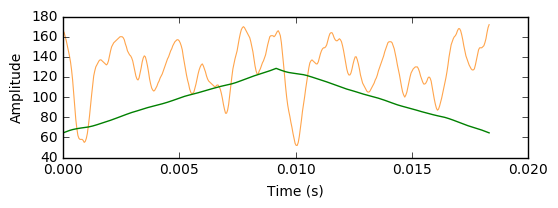

In [20]:
#create a time variable in seconds
time = np.arange(0, float(channel1.shape[0]), 1)/rate

#define a Gaussian curve with width parameter a and then convolve
a = 0.3
gaussian = np.exp(-(time**2)/2*(a**2))
gaussian /= np.trapz(gaussian) # normalize the integral to 1
convolution = np.convolve(channel1, gaussian, 'same')

#plot amplitude (or loudness) over time
plt.figure(1)
plt.subplot(211)
plt.plot(time, channel1, linewidth=0.8, alpha=0.7, color='#ff7f00')
plt.plot(time, convolution, 'g-')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Now let's analyze the power spectrum (of just the left channel) using the FFT.  We note that there is an inherent limit on the resolution between different frequencies since the FFT takes in a signal over a finite time interval, and since it only calculates results for certain discrete frequency values (the "FFT bins").  Since most real signals will have discontinuities at the ends of the measured time, and the FFT assumes periodicity (that is, it assumes the signal repeats), it will most likely assume sharp discontinuities that are not really there.  And since sharp discontinuities have broad frequency spectra, these will cause the signal's frequency spectrum to spread out.  As a result, signal energy which should be concentrated only at one frequency instead leaks into all the other frequencies (this is known as "spectral leakage").  To reduce this effect, we can apply a tapering window function (in this case a Hanning window) which will smooth out any such discontinuity.

Let's make 3 plots of the power spectrum.  The first will just be made by directly applying the FFT, and the second will be made by first applying Hanning windowing before the FFT, and the third will be applying a Gaussian convolution in the frequency domain (out of curiosity).

In [21]:
#generate frequency values
freq = np.fft.rfftfreq(channel1.size, time[1]-time[0])

#FFT to get the power
c1_power = np.fft.rfft(channel1)
c1_power = c1_power/N    #normalize (so that the length doesn't matter)

In [22]:
#apply Hann window and take the FFT
win = np.hanning(N)
windowed_c1_power = (np.fft.rfft(win*channel1))
windowed_c1_power = windowed_c1_power/N    #normalize

In [23]:
#define a Gaussian curve with width parameter a and then convolve
a = 0.3
gaussian = np.exp(-((freq/1000)**2)/2*(a**2))
gaussian /= np.trapz(gaussian) # normalize the integral to 1
convolution = np.convolve(c1_power, gaussian, 'same')

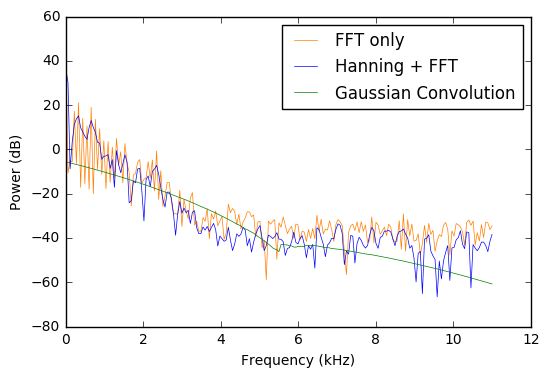

In [24]:
#plot power(in db) against frequency (in kHz)
plt.figure(1)
plt.plot(freq/1000, 10*np.log10(c1_power**2), color='#ff7f00', linewidth=0.5, label='FFT only')
plt.plot(freq/1000, 10*np.log10(windowed_c1_power**2), 'b-', linewidth=0.5, label='Hanning + FFT')
plt.plot(freq/1000, 10*np.log10(convolution**2),'g-', linewidth=0.5, label='Gaussian Convolution')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (dB)')
plt.legend(loc=0)
#plt.subplots_adjust(hspace=1.0)
plt.show()

Here we see the Hanning window successfully reducing some spectral leakage, particularly at low frequencies.